# Zaman Serisi Bileşenleri 
Components of Time-Series


$Y_t = T_t + R_t + S_t + E_t$


# 1 - Trend

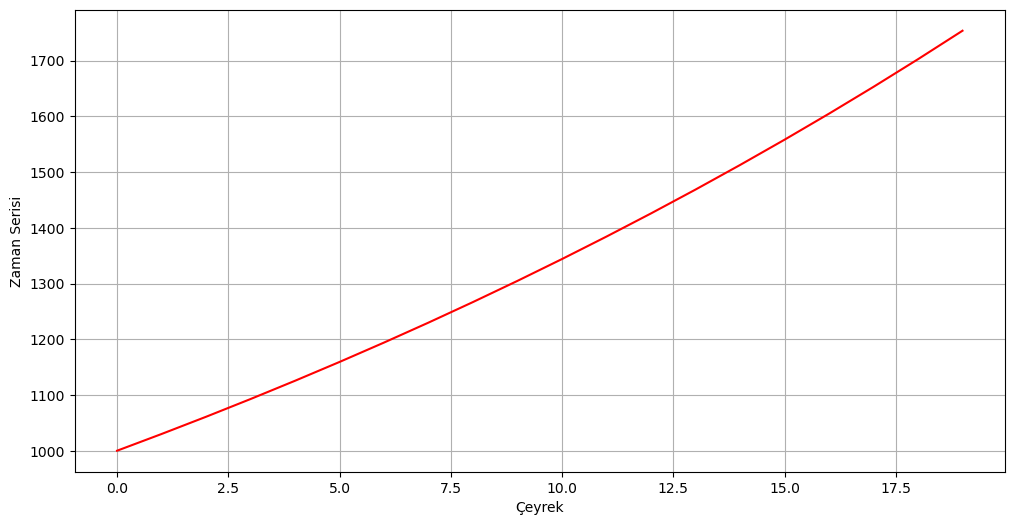

In [9]:
import numpy as np
import matplotlib.pyplot as plt


class TrendTimeSeriesPlot:
    def __init__(self):
        self.years = 5
        self.quarters_per_year = 4
        self.total_quarters = self.years * self.quarters_per_year
        self.time = np.arange(0, self.total_quarters)
        self.trend_growth_rate = 0.03 #Ortalama çeyreklik büyüme
        self.trend = 1000 * (1 + self.trend_growth_rate) ** self.time  

    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.time, self.trend, color='red')
 
        plt.xlabel("Çeyrek")
        plt.ylabel("Zaman Serisi")
        plt.grid(True)
        plt.show()


gdp_trend_ts = TrendTimeSeriesPlot()
gdp_trend_ts.plot()


********************************************************************************************************************************

Diyelim ABD'ye ilişkin GDP verisini bir API aracılığıyla alalım aşağıdaki siteden ve grafiğine bakalım

In [ ]:
pip install fredapi

#f091b0a489e9d87751cdff6b2077b195 FRED API (Kendiniz için https://fred.stlouisfed.org/ sitesinde üyelik oluşturup alabilirsiniz)

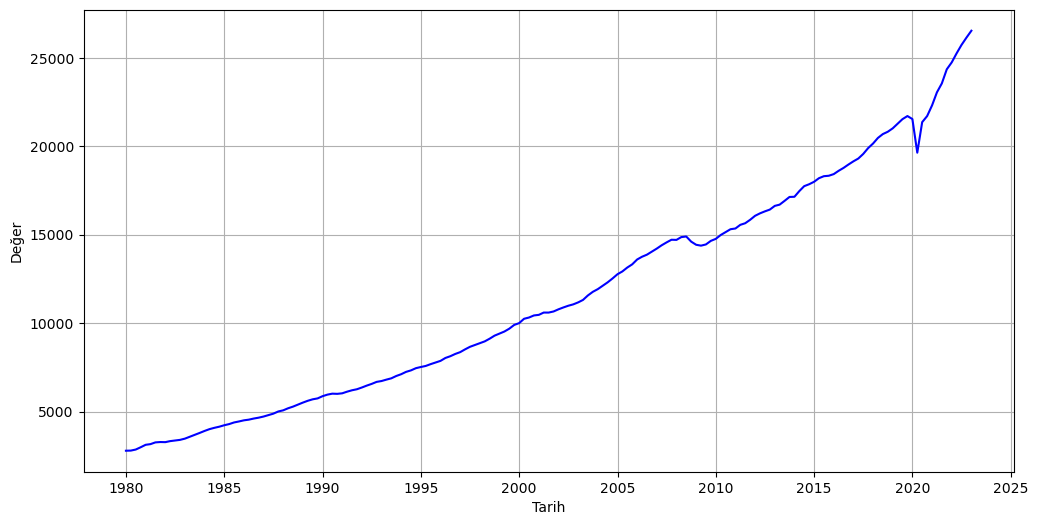

In [13]:
import matplotlib.pyplot as plt
from fredapi import Fred

class FREDDataPlotter:
    def __init__(self, api_key):
        self.api_key = api_key
        self.fred = Fred(api_key=api_key)

    def fetch_data(self, series_id, start_date=None, end_date=None):
        if start_date is None and end_date is None:
            data = self.fred.get_series(series_id)
        else:
            data = self.fred.get_series(series_id, start_date, end_date)
        return data

    def plot_data(self, series_id, start_date=None, end_date=None):
        data = self.fetch_data(series_id, start_date, end_date)

        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data.values, color='blue')
        plt.xlabel("Tarih")
        plt.ylabel("Değer")
        plt.grid(True)
        plt.show()


api_key = "f091b0a489e9d87751cdff6b2077b195"  
fred_plotter = FREDDataPlotter(api_key)

series_id = "GDP"  
start_date = "1980-01-01"
end_date = "2023-06-30"

fred_plotter.plot_data(series_id, start_date, end_date)


----------------------------------------------------

Grafikte açık şekilde gözüktüğü gibi ABD GDPsi için trendi görebiliyoruz. Ancak regresyon ile de zamanın bu veri üzerindeki etkisine ve anlamlılğına bakabiriz.

----------------------------------------------------

In [20]:
import numpy as np
from fredapi import Fred
import statsmodels.api as sm

class FREDDataAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.fred = Fred(api_key=api_key)

    def fetch_data(self, series_id, start_date=None, end_date=None):
        if start_date is None and end_date is None:
            data = self.fred.get_series(series_id)
        else:
            data = self.fred.get_series(series_id, start_date, end_date)
        return data

    def analyze_trend(self, series_id, start_date=None, end_date=None):
        data = self.fetch_data(series_id, start_date, end_date)
        years = np.arange(len(data)).reshape(-1, 1)

        # Bağımlı değişken GDP iken bağımsız değişken zaman (yıl)
        X = sm.add_constant(years)  
        model = sm.OLS(data, X)
        results = model.fit()

        return results


api_key = "f091b0a489e9d87751cdff6b2077b195"
fred_analyzer = FREDDataAnalyzer(api_key)

series_id = "GDP"
start_date = "1980-01-01"
end_date = "2023-06-30"

results = fred_analyzer.analyze_trend(series_id, start_date, end_date)

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     5895.
Date:                Sun, 02 Jul 2023   Prob (F-statistic):          1.88e-134
Time:                        19:45:28   Log-Likelihood:                -1449.1
No. Observations:                 173   AIC:                             2902.
Df Residuals:                     171   BIC:                             2908.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        928.6629    159.983      5.805      0.0

OLS sonucundan anlamlı şekilde 1 yıllık zaman geçmesinin GDP üzerindeki ektisinin katsayısını 123.5142 olarak görebiliriz.

-------

Trend olarak büyüyen bir verinin bundan arındırılması gerekebilir. Bunun için "Differencing" olarak adlandırılan methodu kullanabiliriz. Ancak GDP için bu metodu 2 kez yani "Difference in Difference" olarak kullanacağız.

$
Y'_t = Y_t - Y_{t-1}
$


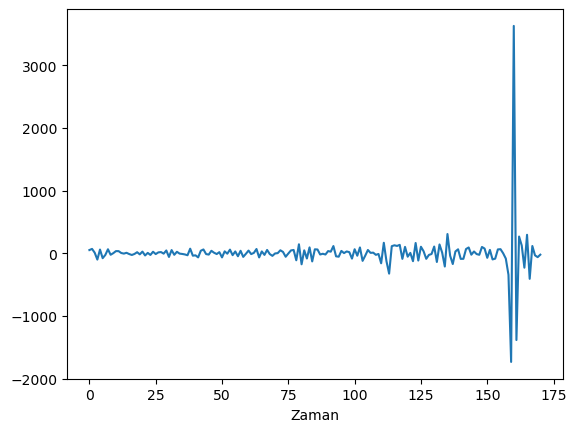

Trend Coefficient: 1.2684303092049254
P-value: 0.9955671126602919


In [29]:
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt

class FREDDataAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.fred = Fred(api_key=api_key)

    def fetch_data(self, series_id, start_date=None, end_date=None):
        if start_date is None and end_date is None:
            data = self.fred.get_series(series_id)
        else:
            data = self.fred.get_series(series_id, start_date, end_date, frequency='q')
        return data

    def difference_data(self, data):
        differenced_data = np.diff(data)
        return differenced_data

    def analyze_trend(self, series_id, start_date=None, end_date=None):
        data = self.fetch_data(series_id, start_date, end_date)
        differenced_data = self.difference_data(data)

  
        trend_coefficient = np.polyfit(range(len(differenced_data)), differenced_data, 1)[0]
        _, residuals, _, _, _ = np.polyfit(range(len(differenced_data)), differenced_data, 1, full=True)
        rss = np.sum(residuals)
        p = 2  
        n = len(differenced_data)
        sigma_hat = np.sqrt(rss / (n - p))
        t_stat = trend_coefficient / sigma_hat
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - p))

        return trend_coefficient, p_value
    
api_key = "f091b0a489e9d87751cdff6b2077b195"
fred_analyzer = FREDDataAnalyzer(api_key)

series_id = "GDP"
start_date = "1980-01-01"
end_date = "2023-06-30"


data = fred_analyzer.fetch_data(series_id, start_date, end_date)


order = 2  #Farkını aldığımız verinin tekrar farkını alıyoruz
differenced_data = data.copy()
for i in range(order):
    differenced_data = np.diff(differenced_data)


plt.plot(differenced_data)

plt.xlabel("Zaman") #Çeyreklik veri

plt.show()


trend_coefficient, p_value = fred_analyzer.analyze_trend(series_id, start_date, end_date)
print("Trend Coefficient:", trend_coefficient)
print("P-value:", p_value)


# 2 - Konjonktürel (Cyclical)

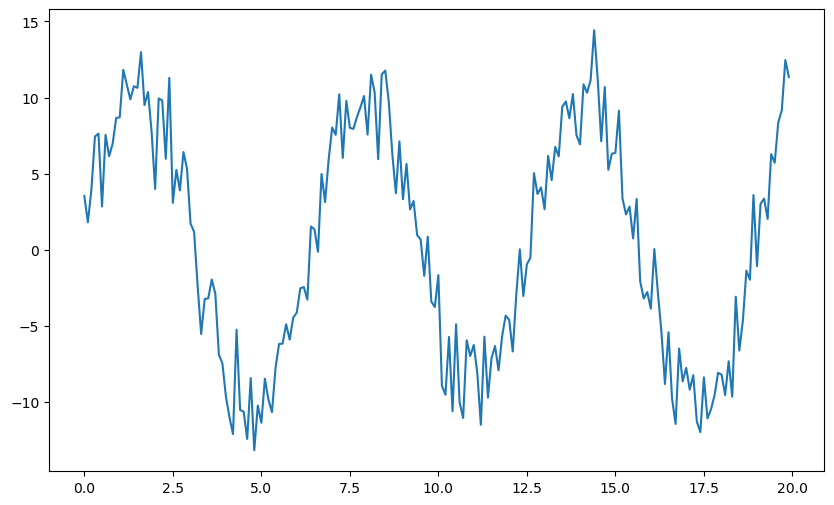

In [34]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
time = np.arange(0, 20, 0.1)
amplitude = np.sin(time) * 10
noise = np.random.normal(0, 2, len(time))
data = amplitude + noise

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, data)

plt.show()


--------

Yeni inşaat projeleri için verilen izinlere dair veriye baktığımızda bunu görebiliriz

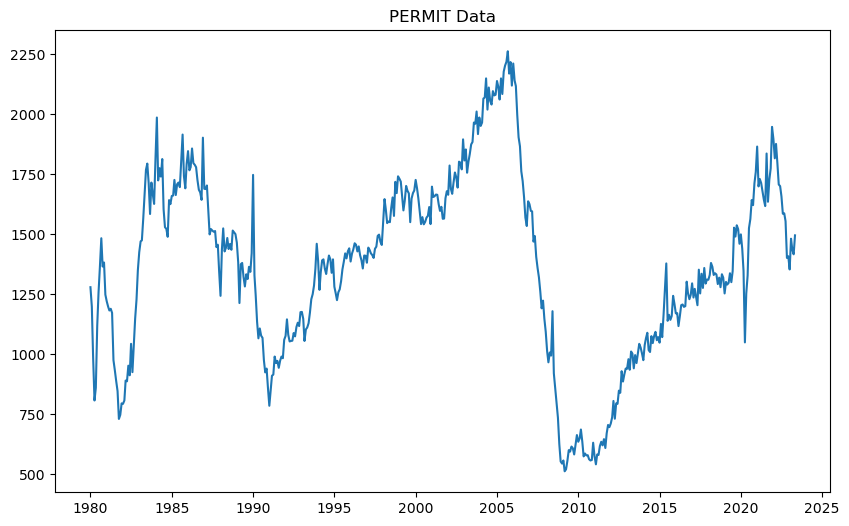

In [66]:
import matplotlib.pyplot as plt
from fredapi import Fred

class PERMIT:
    def __init__(self, api_key):
        self.api_key = api_key
        self.fred = Fred(api_key=api_key)

    def fetch_data(self, series_id, start_date=None, end_date=None):
        if start_date is None and end_date is None:
            data = self.fred.get_series(series_id)
        else:
            data = self.fred.get_series(series_id, start_date, end_date)
        return data

    def plot_data(self, series_id, start_date=None, end_date=None):
        data = self.fetch_data(series_id, start_date, end_date)
        plt.figure(figsize=(10, 6))
        plt.plot(data)
        plt.title(f"{series_id}")
        plt.show()


api_key = "f091b0a489e9d87751cdff6b2077b195"
fred_analyzer = FREDDataAnalyzer(api_key)

series_id = "PERMIT"
start_date = "1980-01-01"
end_date = "2023-06-30"

fred_analyzer.plot_data(series_id, start_date, end_date)


Kaynaklar:

https://www.oecd-ilibrary.org/sites/361fabc3-en/index.html?itemId=/content/component/361fabc3-en

https://www.tcmb.gov.tr/wps/wcm/connect/61089808-d70c-4ec8-8ff4-d1e1ad6e4efa/EN1103eng.pdf?MOD=AJPERES&CACHEID=ROOTWORKSPACE-61089808-d70c-4ec8-8ff4-d1e1ad6e4efa-m3fw4Um

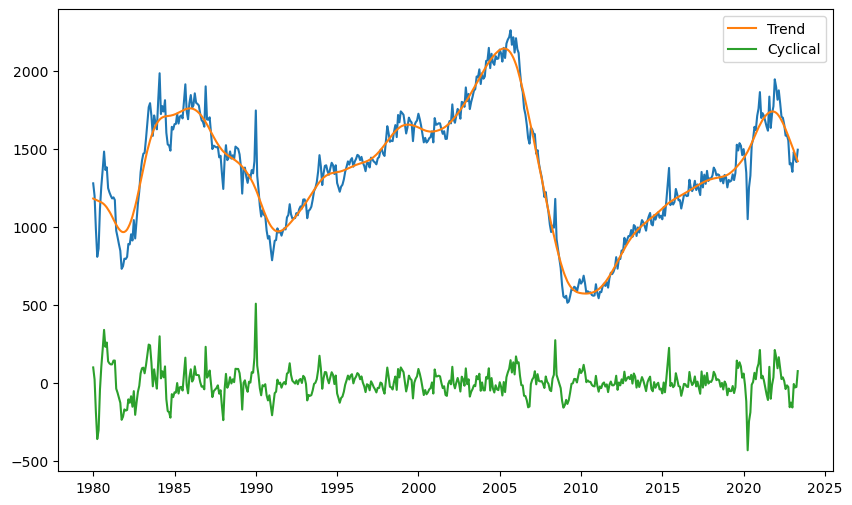

In [64]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred

class PERMIT:
    def __init__(self, api_key):
        self.api_key = api_key
        self.fred = Fred(api_key=api_key)

    def fetch_data(self, series_id, start_date=None, end_date=None):
        if start_date is None and end_date is None:
            data = self.fred.get_series(series_id)
        else:
            data = self.fred.get_series(series_id, start_date, end_date)
        return data

    def apply_hp_filter(self, series_id, start_date=None, end_date=None, lamb=1600):
        data = self.fetch_data(series_id, start_date, end_date)


        cycle, trend = sm.tsa.filters.hpfilter(data, lamb=lamb)

        return cycle, trend

    def plot_hp_filter(self, series_id, start_date=None, end_date=None, lamb=1600):
        data = self.fetch_data(series_id, start_date, end_date)
        cycle, trend = self.apply_hp_filter(series_id, start_date, end_date, lamb)


        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(data)
        ax.plot(trend, label='Trend ')
        ax.plot(cycle, label='Cyclical')

        ax.legend()
        plt.show()


api_key = "f091b0a489e9d87751cdff6b2077b195"
permit_data = PERMIT(api_key)

series_id = "PERMIT"
start_date = "1980-01-01"
end_date = "2023-06-30"
lamb = 1600

permit_data.plot_hp_filter(series_id, start_date, end_date, lamb)


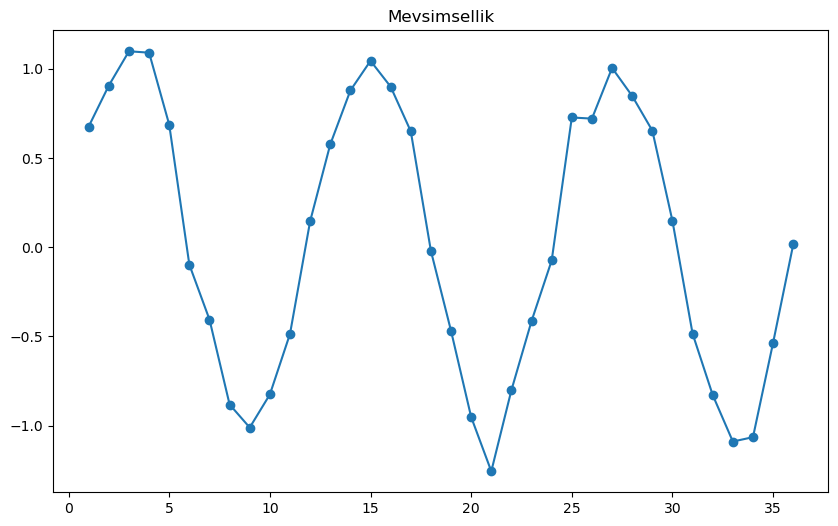

In [63]:


np.random.seed(0)
time = np.arange(1, 37)  
seasonality = np.sin(2 * np.pi * (time / 12)) 


noise = np.random.normal(0, 0.1, size=len(time))
data = seasonality + noise


plt.figure(figsize=(10, 6))
plt.plot(time, data, marker='o')

plt.title('Mevsimsellik')
plt.show()


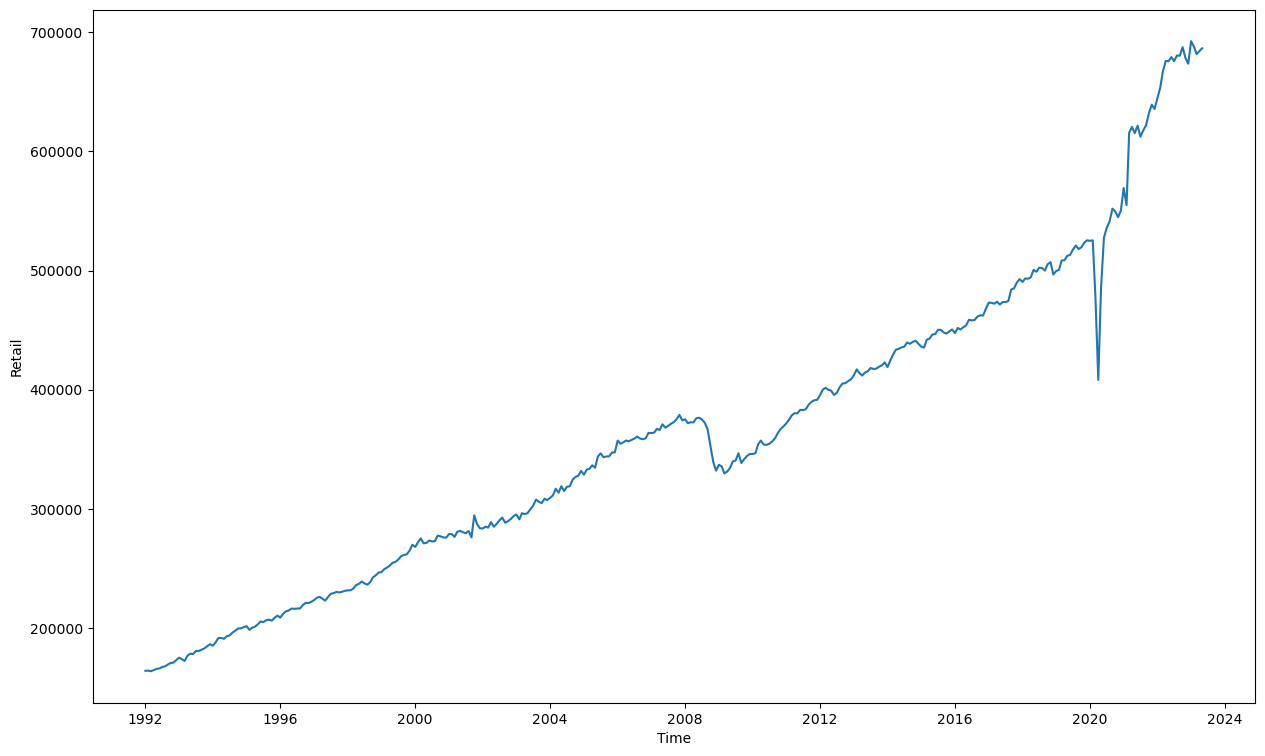

In [62]:



api_key = "f091b0a489e9d87751cdff6b2077b195" 


fred = Fred(api_key=api_key)


series_id = "RSAFS"
data = fred.get_series(series_id)


plt.figure(figsize=(15, 9))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Retail')

plt.show()


Kaynaklar:

https://online.stat.psu.edu/stat510/lesson/5/5.1

https://ocw.metu.edu.tr/pluginfile.php/135369/mod_resource/content/1/STAT%20497_LN7_TIME%20SERIES%20DECOMPOSITION.ppt

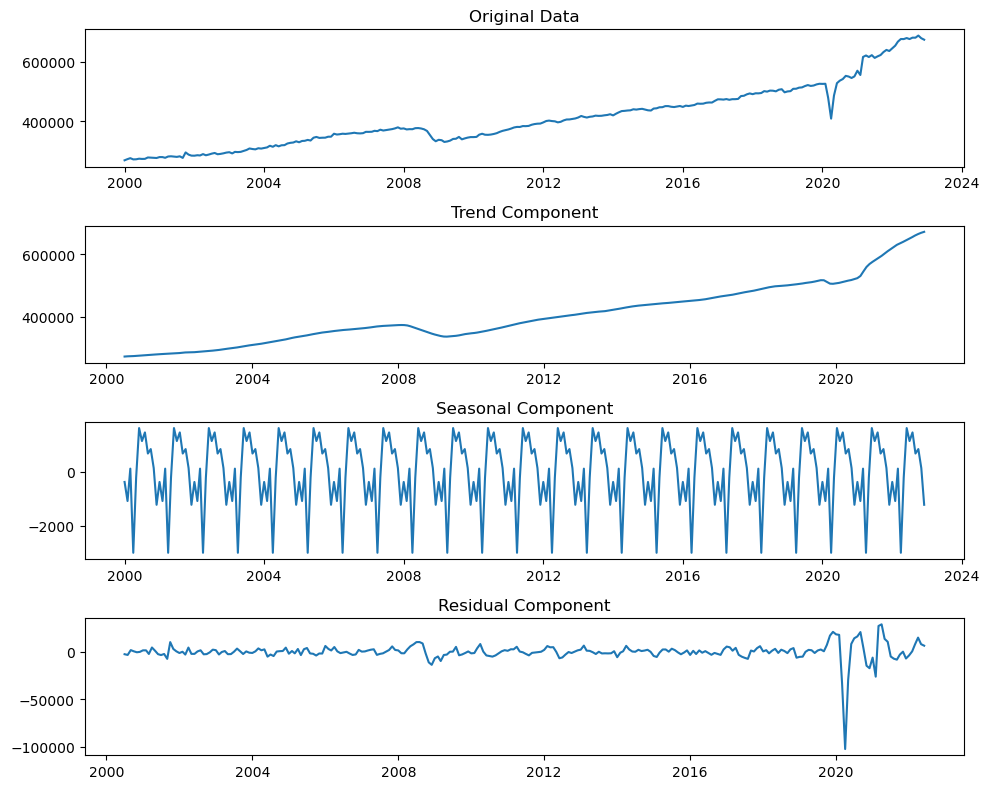

In [52]:

api_key = "f091b0a489e9d87751cdff6b2077b195"

fred = Fred(api_key=api_key)


series_id = "RSAFS"
start_date = "2000-01-01"
end_date = "2022-12-31"
data = fred.get_series(series_id, start_date, end_date)


decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=12)


plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(data)
plt.title('Original Data')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.tight_layout()
plt.show()


ADF Statistic: 1.40140325067795
ADF p-value: 0.997120507334606
Significant Autocorrelation Lags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


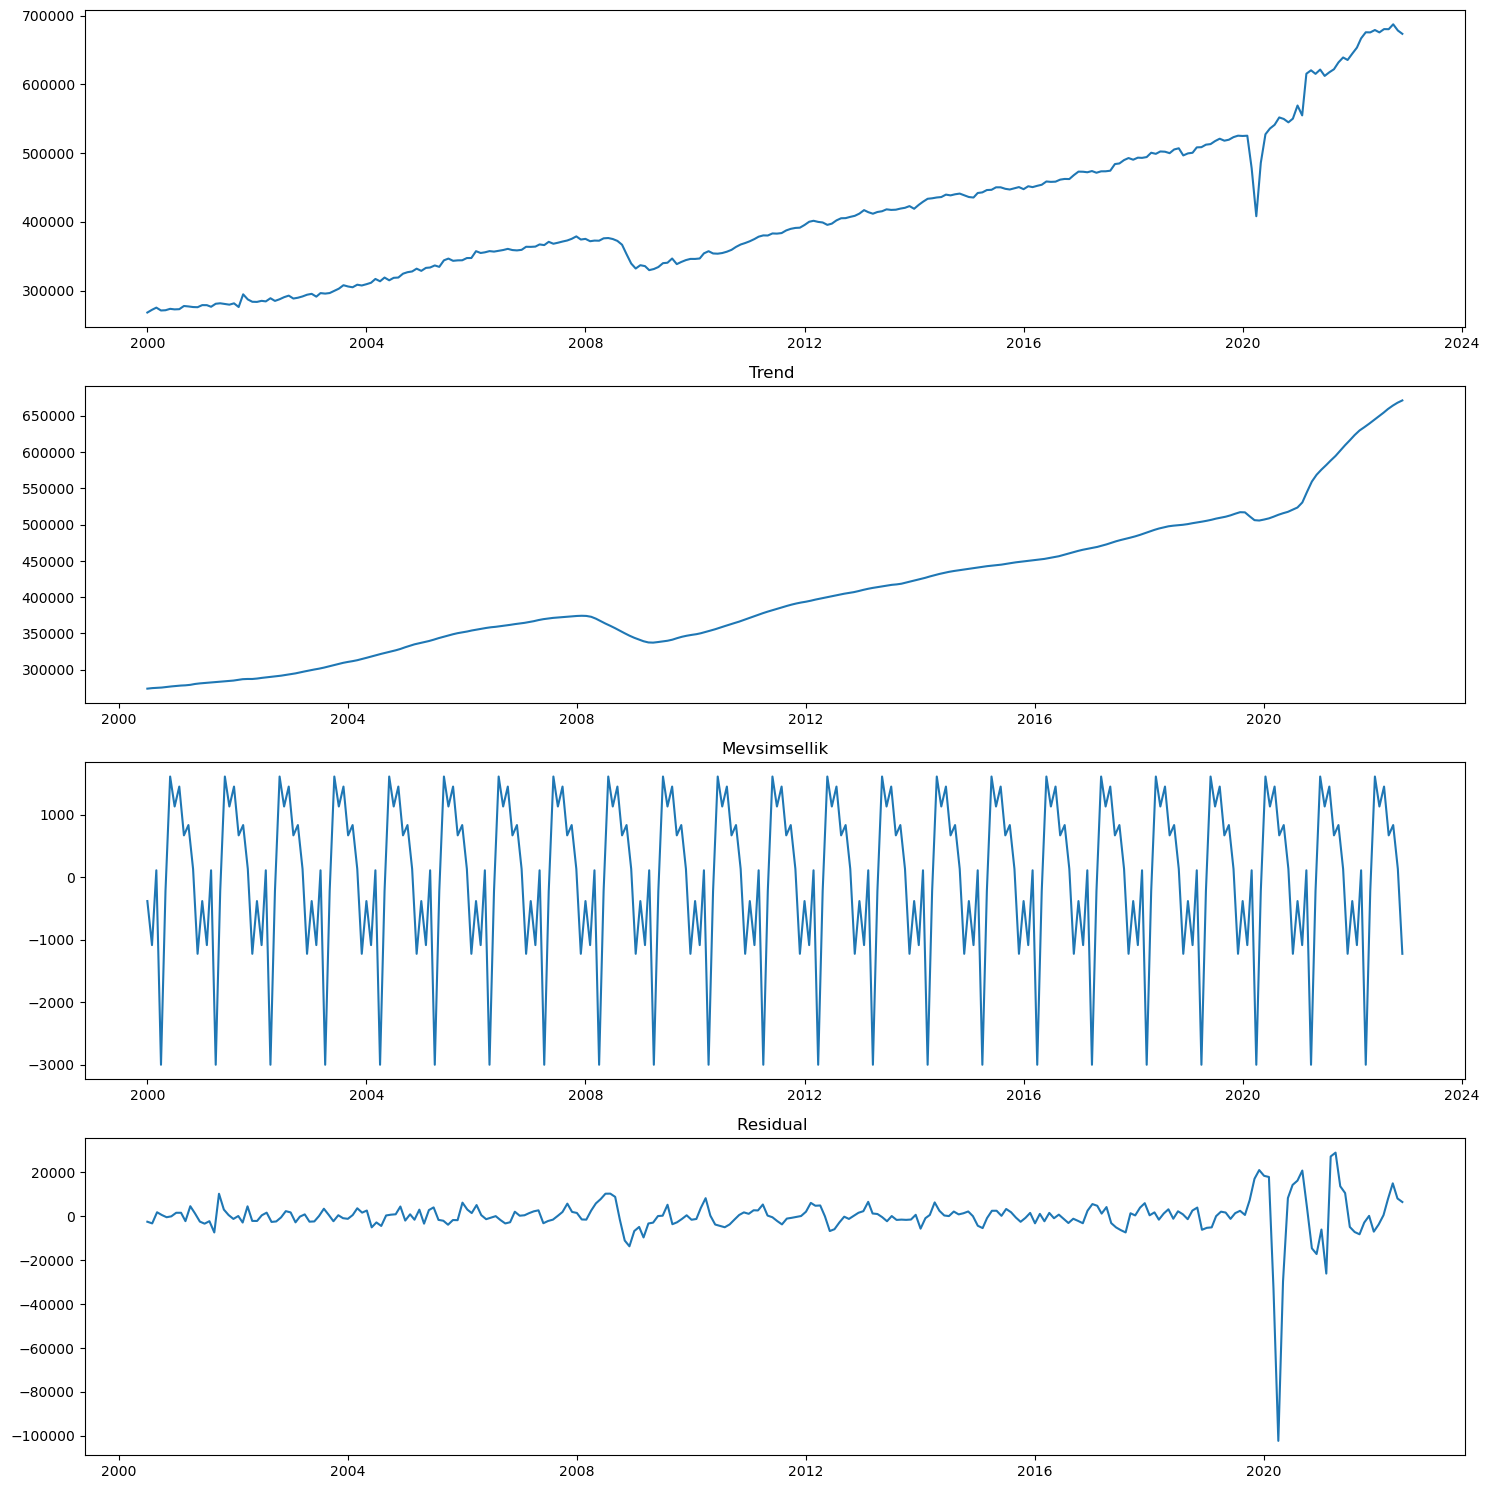

In [60]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred

api_key = "f091b0a489e9d87751cdff6b2077b195"


fred = Fred(api_key=api_key)


series_id = "RSAFS"
start_date = "2000-01-01"
end_date = "2022-12-31"
data = fred.get_series(series_id, start_date, end_date)


decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=12)


adf_test = sm.tsa.stattools.adfuller(data)
adf_statistic = adf_test[0]
adf_pvalue = adf_test[1]


acf = sm.tsa.stattools.acf(data, fft=True)
acf_significant_lags = [i for i, val in enumerate(acf) if abs(val) > 2 / (len(data) ** 0.5)]


plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(data)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend ')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Mevsimsellik')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual ')
plt.tight_layout()


print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_pvalue)


print("Significant Autocorrelation Lags:", acf_significant_lags) # Mevsimsellik için


plt.show()
